<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод:</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [ ]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression, Ridge

warnings.filterwarnings("ignore")

## Подготовка
Импортируем данные

In [ ]:
try:
    data = pd.read_csv('C:\\Users\\Ксения\\Downloads\\taxi.csv')
except:
    data = pd.read_csv('/datasets/taxi.csv')

Выведем основную информацию о наборе данных и первые 5 строк.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [ ]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Заметим, что данные содержат 2 признака: дата (строковый тип данных) и количество заказов (целочисленный тип данных). Для последующей работы с данными сделаем следующее:

- Дату сбора информации сделаем индексом;
- строовый тип даты изменим на тип дата;
- отсортируем индекс в порядке возрастания;
- ресемплируем данные по одному часу.

Затем выведем основную инфрмацию о данных и убедимся, что данные были изменены.

In [ ]:
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S')
data.set_index('datetime', inplace=True)

data = data.resample('1H').sum()
data.sort_index(ascending=True, inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Вывод:

В ходе данного шага нами был получен набор данных и изменен для удобства последующей работы с ним, а также были выброшены аномальные значения.

## Анализ

Посмотрим как изменяется количество заказов с течением времени.

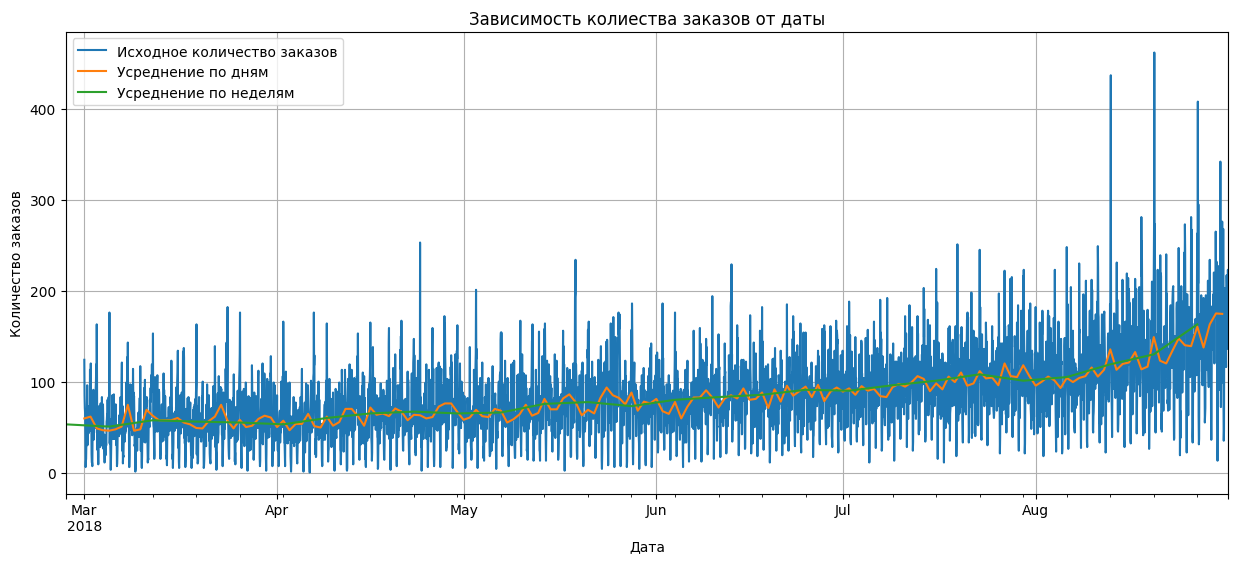

In [ ]:
data.plot(ax=plt.gca(),figsize=(15,6), grid=True)
data.resample('1D').median().plot(ax=plt.gca(),figsize=(15,6), grid=True)
data.resample('1W').median().plot(ax=plt.gca(),figsize=(15,6), grid=True)
plt.legend(['Исходное количество заказов', 'Усреднение по дням', 'Усреднение по неделям'])
plt.title('Зависимость колиества заказов от даты')
plt.xlabel('Дата')
plt.ylabel('Количество заказов');

Как видим количество заказов постепенно увеличивается. Построим график тренда, чтобы более детально рассмотреть изменения.

<Axes: xlabel='datetime'>

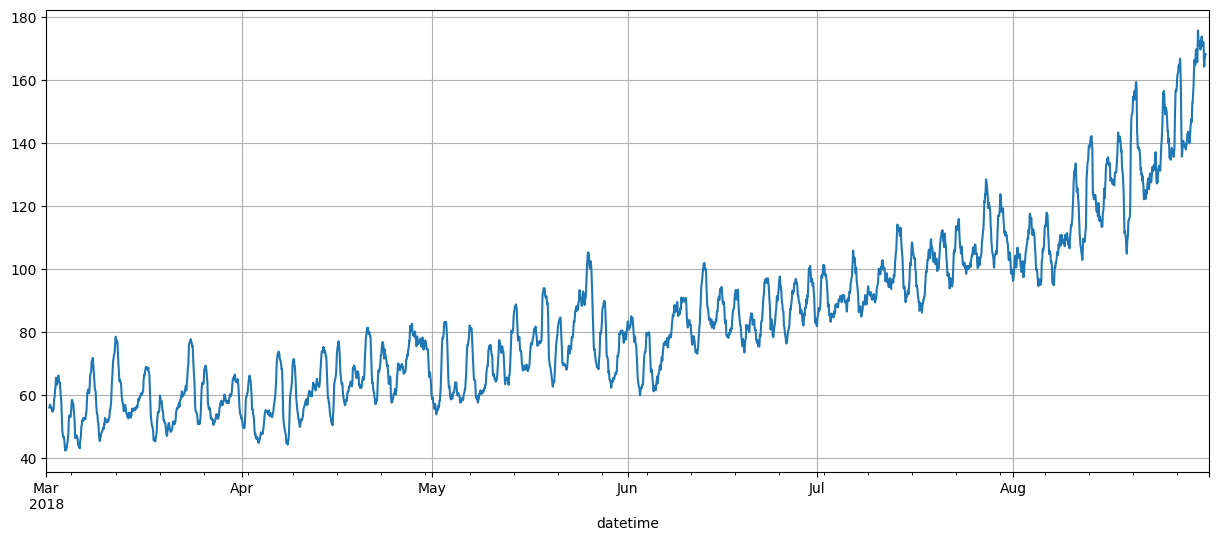

In [ ]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(15,6))
decomposed.trend.plot(ax=plt.gca(), grid=True)

Как видим количество заказов постоянно растет, однако скорость роста начная с июня больше, чем до этого.

Теперь рассмотрим как количество заказов зависит от сезонности. Для этого ограничим период наблюдения до 10 дней, чтобы надлюдать ежедневную сезоннность в изменении данных.

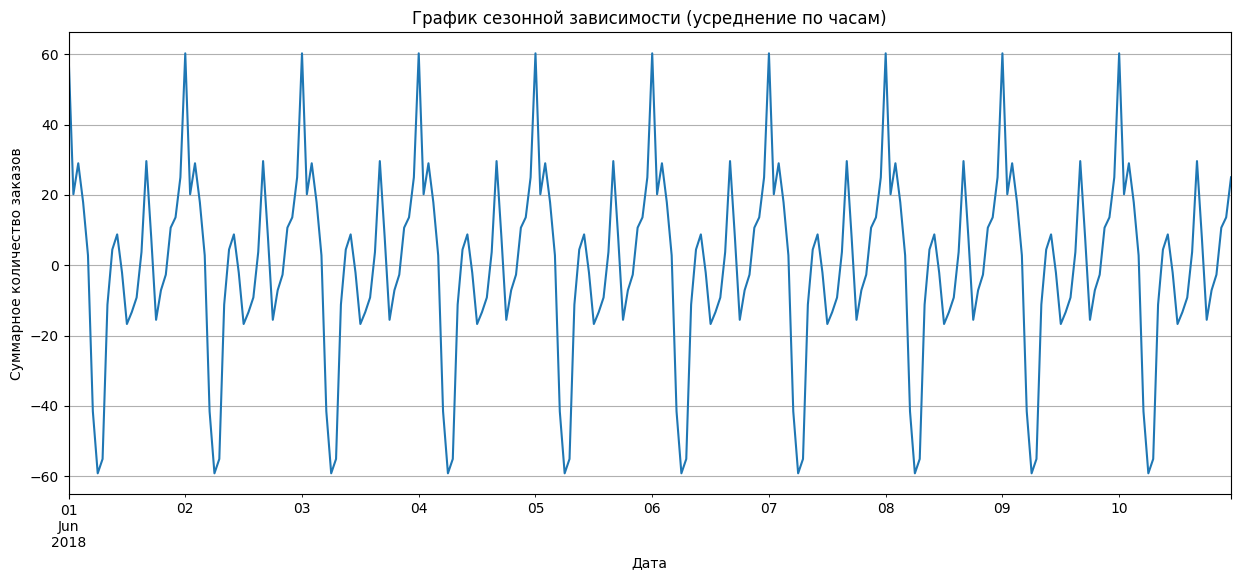

In [ ]:
plt.figure(figsize=(15,6))
decomposed.seasonal['2018-06-01':'2018-06-10'].plot(ax=plt.gca(), grid=True)
plt.title('График сезонной зависимости (усреднение по часам)')
plt.xlabel('Дата')
plt.ylabel('Суммарное количество заказов');

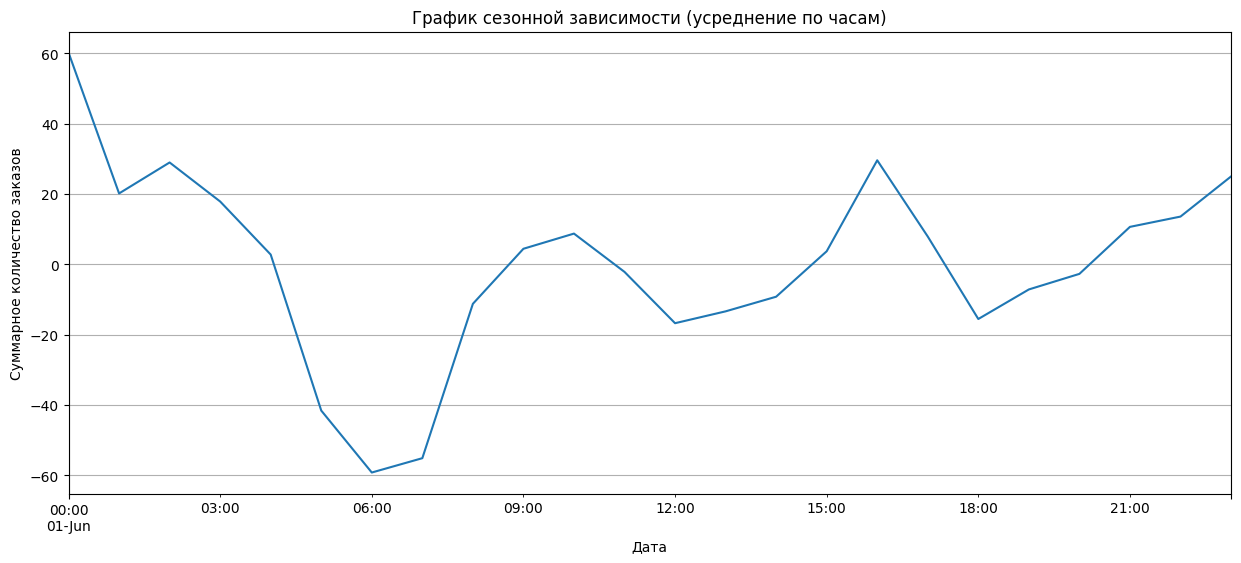

In [ ]:
plt.figure(figsize=(15,6))
decomposed.seasonal['2018-06-01':'2018-06-01'].plot(ax=plt.gca(), grid=True)
plt.title('График сезонной зависимости (усреднение по часам)')
plt.xlabel('Дата')
plt.ylabel('Суммарное количество заказов');

Так, мы видим, что максимальное количество заказов характерно для 12:00, когда количество общественного транспорта существенно меньше по сравнению с дневными часами, а минимум приходится на 6:00, когда люди спят или только встают. Локальные максимумы наблюдаются также для обеденных часов и вечернего времени, когда люди возращаются с работы.

Также проверим наличие недельной сезонности.

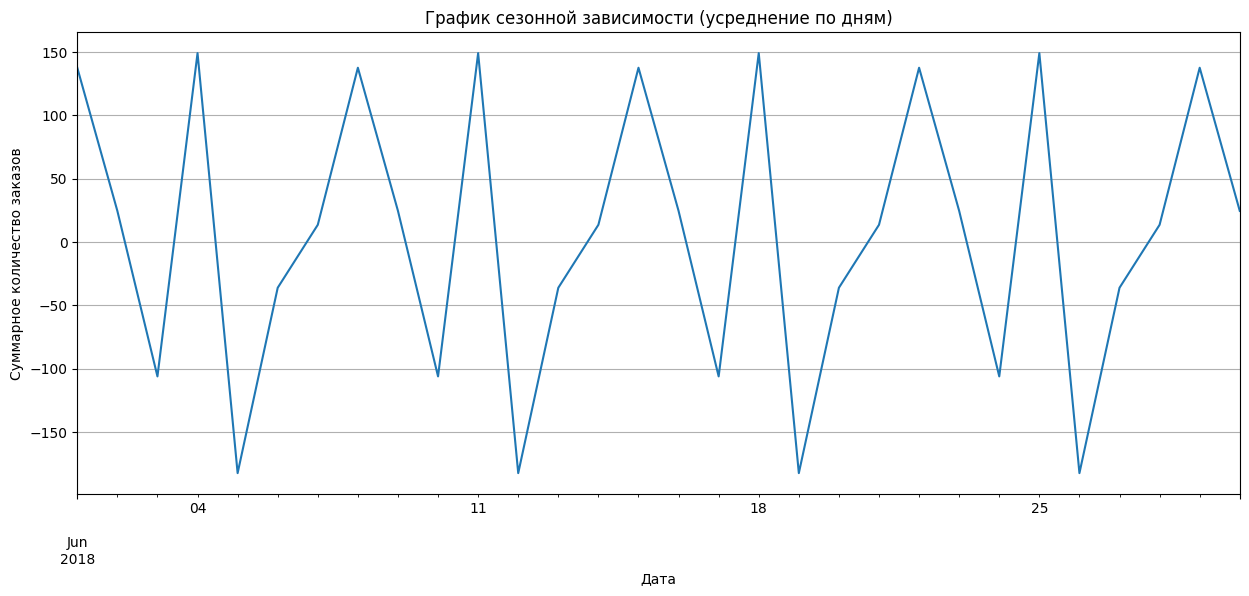

In [ ]:
decomposed = seasonal_decompose(data.resample('1D').sum())

plt.figure(figsize=(15,6))
decomposed.seasonal['2018-06':'2018-06'].plot(ax=plt.gca(), grid=True)
plt.title('График сезонной зависимости (усреднение по дням)')
plt.xlabel('Дата')
plt.ylabel('Суммарное количество заказов');

Как видим для данных прослеживается также недельная сезонность. Так больше всего такси вызывают по понедельникам, средам и воскресеньям, а меньше всего по вторникам и четвергам. Для пятницы и субботы характерно среднее значение количества вызовов.

Вывод:

В ходе выполнения данного шага нами были проанализированы данные. Найден их тренд и найдены сезонные зависимости.

## Обучение
Подготовим выборки. Для этого напишем функцию, которая будет создавать признаки и разделять их на выборки.

In [ ]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['week'] = data.index.week

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

    train_valid, test = train_test_split(data, shuffle=False, random_state=12345, test_size=0.1)
    train, valid = train_test_split(train_valid, shuffle=False, random_state=12345, test_size=0.2)

    train.dropna(inplace=True)
    target_train = train['num_orders']
    features_train = train.drop('num_orders', axis=1)
    target_valid = valid['num_orders']
    features_valid = valid.drop('num_orders', axis=1)
    target_test = test['num_orders']
    features_test = test.drop('num_orders', axis=1)

    return target_train, features_train, target_valid, features_valid, target_test, features_test

Так как перед нами стоит задача регрессии, то для ее решения построим следующие модели:

- линейнаяя регрессия
- регрессия дерева решений
- ridge регрессия

In [ ]:
model_name = []
lag = []
rolling_size = []
rmse = []

for max_lag in range(0, 97, 24):
    for rolling_mean_size in range(168, 673, 168):
        #Создание признаков
        target_train, features_train, target_valid, features_valid, target_test, features_test = (
            make_features(data, max_lag, rolling_mean_size))

        #Нормировка данных
        features_num_names = features_train.columns
        scaler = StandardScaler()
        scaler.fit(features_train[features_num_names])
        features_train[features_num_names] = scaler.transform(features_train[features_num_names])
        features_valid[features_num_names] = scaler.transform(features_valid[features_num_names])
        features_test[features_num_names] = scaler.transform(features_test[features_num_names])

        #Линейная регрессия
        lin_reg = LinearRegression(copy_X=True)
        lin_reg.fit(features_train, target_train)
        model_name.append('Линейная регрессия')
        lin_reg_pred = lin_reg.predict(features_valid)
        lin_reg_rmse = mean_squared_error(target_valid, lin_reg_pred, squared=False)
        rmse.append(lin_reg_rmse)
        lag.append(max_lag)
        rolling_size.append(rolling_mean_size)

        print('Значения метрики rmse для обученных моделей при max_lag = {0}, rolling_mean_size = {1}'
              .format(max_lag, rolling_mean_size))
        print('RMSE метрика для модели линейной регрессии = {0}'.format(round(lin_reg_rmse, 1)))

        #Регрессияя дерева решений
        best_tree = DecisionTreeRegressor()
        best_rmse = 1000000

        for depth in range(1, 31):
            tree = DecisionTreeRegressor(max_depth=depth, random_state=12345)
            tree.fit(features_train, target_train)
            tree_pred = tree.predict(features_valid)
            tree_rmse = mean_squared_error(target_valid, tree_pred, squared=False)
            if tree_rmse < best_rmse:
                best_tree = tree
                best_rmse = tree_rmse

        model_name.append('Регрессия дерева решений')
        rmse.append(best_rmse)
        lag.append(max_lag)
        rolling_size.append(rolling_mean_size)

        print('RMSE метрика для модели регрессии дерева решений= {0}'.format(round(best_rmse, 1)))

        #Ridge регрессия
        best_ridge = Ridge();
        best_rmse = 1000000

        for alpha in range(1, 10):
            for max_iter in range(1, 16000, 1000):
                ridge = Ridge(alpha=alpha, max_iter=max_iter, copy_X=True, random_state=12345);
                ridge.fit(features_train, target_train);
                ridge_pred = ridge.predict(features_valid);
                ridge_rmse = mean_squared_error(target_valid, ridge_pred, squared=False)
                if ridge_rmse < best_rmse:
                    best_ridge = ridge
                    best_rmse = ridge_rmse

        model_name.append('Ridge регрессия')
        rmse.append(best_rmse)
        lag.append(max_lag)
        rolling_size.append(rolling_mean_size)

        print('RMSE метрика для модели Ridge регрессии = {0}'.format(round(best_rmse, 1)))

        print('\n' * 3)

Значения метрики rmse для обученных моделей при max_lag = 0, rolling_mean_size = 168
RMSE метрика для модели линейной регрессии = 42.6
RMSE метрика для модели регрессии дерева решений= 34.1
RMSE метрика для модели Ridge регрессии = 42.6




Значения метрики rmse для обученных моделей при max_lag = 0, rolling_mean_size = 336
RMSE метрика для модели линейной регрессии = 43.0
RMSE метрика для модели регрессии дерева решений= 33.5
RMSE метрика для модели Ridge регрессии = 42.9




Значения метрики rmse для обученных моделей при max_lag = 0, rolling_mean_size = 504
RMSE метрика для модели линейной регрессии = 43.2
RMSE метрика для модели регрессии дерева решений= 35.2
RMSE метрика для модели Ridge регрессии = 43.0




Значения метрики rmse для обученных моделей при max_lag = 0, rolling_mean_size = 672
RMSE метрика для модели линейной регрессии = 43.4
RMSE метрика для модели регрессии дерева решений= 33.5
RMSE метрика для модели Ridge регрессии = 43.0




Значения метрики rmse для обученных 

Теперь выберем наилучшую модель

In [ ]:
model_params = pd.DataFrame(
    {'Название модели': model_name,
     'RMSE': rmse,
     'max_lag': lag,
     'rolling_mean_size': rolling_size})
model_params.sort_values(by='RMSE', ascending=True, inplace=True)
model_params

,Название модели,RMSE,max_lag,rolling_mean_size
50,Ridge регрессия,29.249254,96,168
48,Линейная регрессия,29.255577,96,168
56,Ridge регрессия,29.381254,96,504
53,Ridge регрессия,29.382350,96,336
59,Ridge регрессия,29.389904,96,672
51,Линейная регрессия,29.421299,96,336
54,Линейная регрессия,29.455806,96,504
57,Линейная регрессия,29.528848,96,672
38,Ridge регрессия,29.541133,72,168
36,Линейная регрессия,29.547529,72,168


Как видим наилучших результатов мы смогли добиться для Ridge регрессии, при количестве отстающих значений = 96 (4 суток), а ширине окна усреднения = 168 (1 неделя). Создадим выборку на основе тренировочной и валидационой выюорок для последующего тестирования модели.

In [ ]:
target_train, features_train, target_valid, features_valid, target_test, features_test = (
            make_features(data, 96, 168))

features_train = pd.concat([features_train, features_valid], ignore_index=True)
target_train = pd.concat([target_train, target_valid], ignore_index=True)

features_num_names = features_train.columns
scaler = StandardScaler()
scaler.fit(features_train[features_num_names])
features_train[features_num_names] = scaler.transform(features_train[features_num_names])
features_test[features_num_names] = scaler.transform(features_test[features_num_names])

Вывод:

В ходе данного шага нами были подготовлены выборки и обучены несколько моделей, среди которых наилучшей оказалась модель регрессии дерева решений. Проверим данную модель на тестовых данных следующим шагом.

## Тестирование

In [ ]:
best_ridge.fit(features_train, target_train)
ridge_pred = best_ridge.predict(features_test)
ridge_rmse = mean_squared_error(target_test, ridge_pred, squared=False)
print('RMSE метрика для модели Ridge регрессии = {0}'.format(round(ridge_rmse, 1)))

RMSE метрика для модели Ridge регрессии = 40.8


In [ ]:
ridge_pred = pd.DataFrame(ridge_pred)
ridge_pred.index = target_test.index

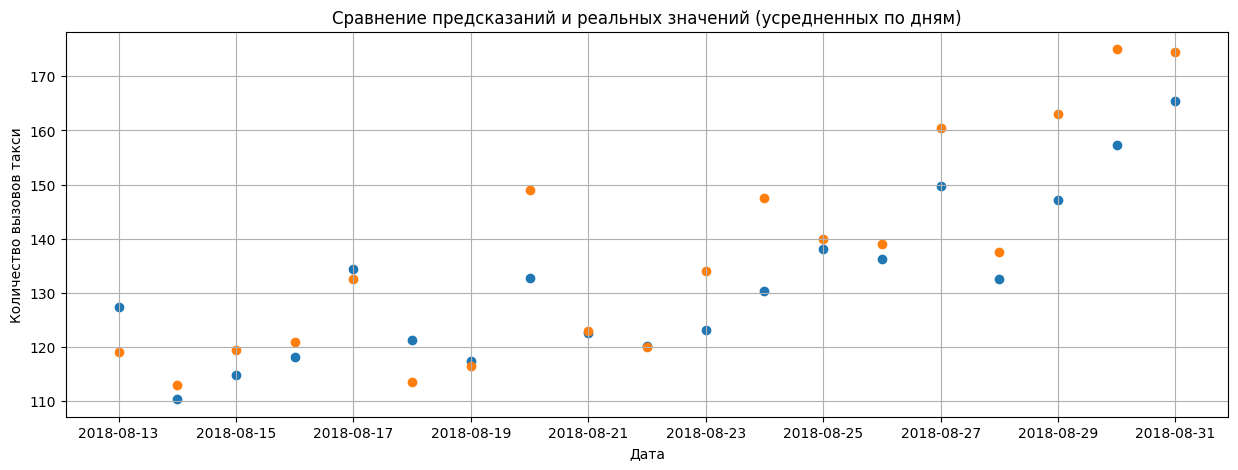

In [ ]:
ridge_pred = ridge_pred.resample('1D').median()
target_test = target_test.resample('1D').median()

plt.figure(figsize=(15,5))
plt.title('Сравнение предсказаний и реальных значений (усредненных по дням)')
plt.xlabel('Дата')
plt.ylabel('Количество вызовов такси')
plt.grid(True)
plt.scatter(ridge_pred.index, ridge_pred);
plt.scatter(target_test.index, target_test);

Вывод:

Как видим, полученная модель удовлетворяет заданному пороговому значению rmse метрики, но при этом количество полного совпадения довольно мала.

## Вывод:

В ходе данного проекта перед нами стояла задача построения модели, которая будет предсказывать количество заказов такси на следующий час. Перед построением модели данные были нами изучены и проанализированы. Были определены тренды и сезонные зависимости, а также отброшены аномальные значения.

Затем нами были подготовлены выборки и созданы признаки, по которым впоследствии нами были обучены 3 модели с разными гиперпараметрами и лучшей оказалась модель Ridge регрессии. Итоговое значение rmse метрики на тестовой выборке = 40.8.